# **DA5401 A4 — GMM-Based Synthetic Sampling for Imbalanced Data**

## Part A: Baseline Model and Data Analysis

We will be using a dataset on credit card fraud which is available in Kaggle. There is no need to do feature engineering as the data had been preprocessed using PCA

In [165]:
import pandas as pd

df=pd.read_csv('creditcard.csv')

We will visualize the number of fraudulent and non-fraudulent cases in a bar graph 

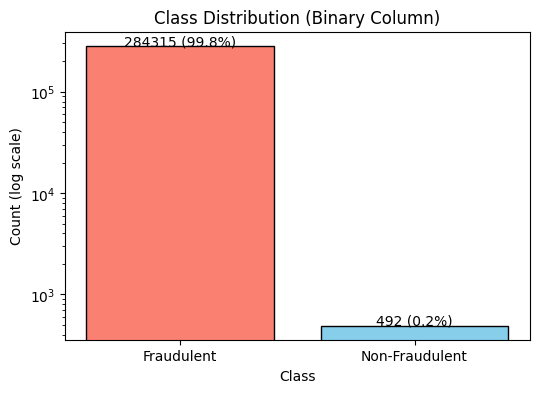

Degree of imbalance is 0.00173


In [166]:
import matplotlib.pyplot as plt

counts = df["Class"].value_counts()
total = counts.sum()

plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values, 
        color=["salmon", "skyblue"], edgecolor="black")

# Titles and axis labels
plt.title("Class Distribution (Binary Column)")
plt.xlabel("Class")
plt.ylabel("Count (log scale)")

# Set y-axis to log scale
plt.yscale("log")

# Replace x-ticks with class labels
plt.xticks([0, 1], ["Fraudulent", "Non-Fraudulent"])

# Annotate bars with counts and percentages
for i, val in enumerate(counts.values):
    percent = (val / total) * 100
    plt.text(i, val + 11.3, f"{val} ({percent:.1f}%)", 
             ha='center', fontsize=10)

plt.show()

deg_imbalance=min(counts)/max(counts)
print(f'Degree of imbalance is {round(deg_imbalance,6)}')


The degree of imablance of the dataset is **0.00173**

Now we will apply standardization because feature like amount and time has not been standardized.

In [167]:
from sklearn.preprocessing import StandardScaler
X = df.drop("Class", axis=1)
y = df["Class"]
scaler = StandardScaler()
X[['Amount']] = scaler.fit_transform(X[['Amount']] )
X[['Time']] = scaler.fit_transform(X[['Time']] )


We will now split the original dataset into training and testing sets while ensuring the test set retains its original imbalance.

In [168]:
from sklearn.model_selection import train_test_split

# Split into train and test while keeping imbalance ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,         # 20% for testing
    random_state=42,       
    stratify=y             # preserves class imbalance
)

print("Train set distribution:\n", y_train.value_counts(normalize=True))
print("Test set distribution:\n", y_test.value_counts(normalize=True))

Train set distribution:
 Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Test set distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


Now we train a logistic regression classifier to evaluate the model's performance on the test set. We take note of metrics like precision, F1 score and accuracy of the minority class.

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
model = LogisticRegression()
model.fit(X_train, y_train)
yhat = model.predict(X_test)
report_dict=classification_report(y_test, yhat,output_dict=True)
precision_min_baseline = report_dict['1']['precision']
recall_min_baseline    = report_dict['1']['recall']
f1_min_baseline        = report_dict['1']['f1-score']
accuracy_baseline = report_dict['accuracy']
print('Accuracy of the model:')
print(f'  accuracy   : {round(accuracy_baseline,5)}\n')
print('Performance metrics for the minority class:')
print(f'  precision  : {round(precision_min_baseline,5)}')
print(f'  recall     : {round(recall_min_baseline,5)}')
print(f'  f1         : {round(f1_min_baseline,5)}')

Accuracy of the model:
  accuracy   : 0.99916

Performance metrics for the minority class:
  precision  : 0.82895
  recall     : 0.64286
  f1         : 0.72414


Accuarcy is misleading in this highly imbalanced dataset. Most of the data is for the non-fraudulent class which account for about 99.8% data, so even if it predicts all the outcome as non-fradulent the overall accuracy will be 99.8% even though it got all the fradulent cases wrong.

## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

### Theory

**SMOTE (Synthetic Minority Oversampling Technique):**

 - It generates synthetic samples by interpolating between existing minority data points and their nearest neighbors.
 - It does not explicitly model the true data distribution, which can lead to noisy or unrealistic samples.
 - It is problematic in sparse or overlapping regions, where interpolation may create misleading synthetic points.

**GMM-based Synthetic Sampling:**

 - Represents the underlying probability distribution as a weighted combination of multiple Gaussian clusters. 
 - It generates new synthetic samples by sampling from these Gaussian components.
 - GMM preserves the natural variability and multiple modes of the data distribution unlike SMOTE.

**Why GMM does better?**

 - GMM explicitly models the probability distribution of the minority class as a mixture of Gaussian components. 
 - Each Gaussian captures a sub-group of the data, and new points are sampled from these distributions. 
 - This allows GMM to preserve diversity and generate samples that reflect complex shapes or multiple clusters in the feature space.

### GMM Implementation

We will isolate the minority class from the training dataset

In [170]:
from sklearn.mixture import GaussianMixture

# Extract minority class only
X_minority = X_train[y_train == 1]
X_majority = X_train[y_train == 0]

We will use Bayesian Information Criterion (BIC) to determined the optimal number of components (k) for the GMM.

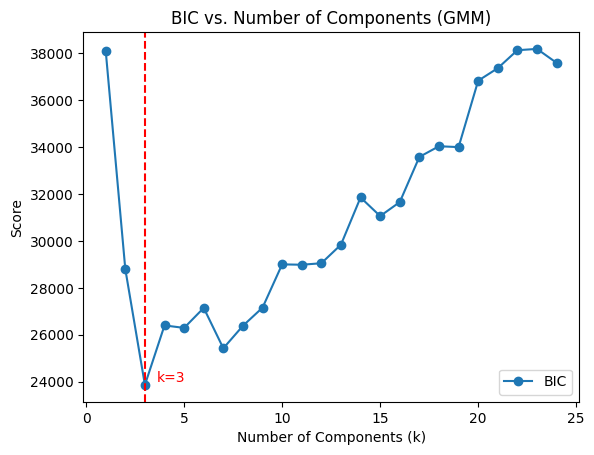

In [181]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

bic_scores = []
ks = range(1, 25)

for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_minority)
    bic_scores.append(gmm.bic(X_minority))

plt.plot(ks, bic_scores, label='BIC', marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('Score')
plt.legend()

# Add vertical line at k=3
plt.axvline(x=3, color='red', linestyle='--', label='k=3')
plt.text(3.6, min(bic_scores), 'k=3', color='red', fontsize=10, va='bottom')
plt.title("BIC vs. Number of Components (GMM)")
plt.show()


The minimum score is when **k=3**, so we will fit the GMM with **3 components**

In [172]:
# Fit GMM with k=3 components
k = 3   
gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
gmm.fit(X_minority)
None 

We will generate synthetic data for the minority class so that the number of data points matches with the majority class and then add the synthetic data to the original dataset.

In [173]:
# Generate synthetic minority samples
X_synthetic, _ = gmm.sample(n_samples=len(X_majority)-len(X_minority)) 
# Combine synthetic samples with original minority data
X_minority_balanced = np.vstack([X_minority, X_synthetic])
y_minority_balanced = np.ones(X_minority_balanced.shape[0])

# Keep majority class unchanged
X_majority = X_train[y_train == 0]
y_majority = np.zeros(X_majority.shape[0])

# Final balanced training set
X_train_gmm = np.vstack([X_majority, X_minority_balanced])
y_train_gmm = np.hstack([y_majority, y_minority_balanced])


### CBU+GMM Implementation

We will first use elbow method to identify the number of clusters we have to divide the majority class into.

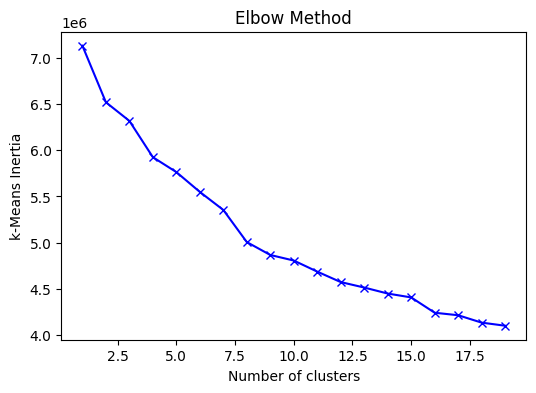

Optimal Number Of Clusters of Majority Group: 8


In [174]:
from kneed import KneeLocator
majority_samples = X_train[y_train == 0]

inertia = []
K_range = range(1, 20)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(majority_samples)
    inertia.append(kmeans.inertia_)

# KneeLocator for Optimal Number of Clusters
knee_locator = KneeLocator(K_range, inertia, curve='convex', direction='decreasing')
optimal_k = knee_locator.knee


# plot elbow curve
plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('k-Means Inertia')
plt.title('Elbow Method')
plt.show()

print(f"Optimal Number Of Clusters of Majority Group: {optimal_k}")

We now use K-Means to split the majority class into **11 clusters**. From each of the cluster we select few of the samples depending on its size. We ensure that the samples are selected bade on the proportion of that cluster. We will undersample points so that the total number of points is twice of the minoroty class.

In [175]:
from sklearn.cluster import KMeans
import pandas as pd

# Separate majority and minority
X_majority = X_train[y_train == 0]
X_minority = X_train[y_train == 1]

# Choose k clusters for majority class
k = 11  # from elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
majority_clusters = kmeans.fit_predict(X_majority)

# Add cluster labels
majority_df = pd.DataFrame(X_majority.copy())
majority_df["Cluster"] = majority_clusters

# Desired majority size 
target_majority_size = 2 * len(X_minority)  

# Compute proportional quota per cluster
cluster_counts = majority_df["Cluster"].value_counts()
cluster_quota = (cluster_counts / cluster_counts.sum() * target_majority_size).astype(int)+1

# Sample from each cluster proportionally
majority_selected = []
for cid, quota in cluster_quota.items():
    cluster_points = majority_df[majority_df["Cluster"] == cid].drop("Cluster", axis=1)
    sampled = cluster_points.sample(n=min(quota, len(cluster_points)), random_state=42)
    majority_selected.append(sampled)

X_majority_cbu = pd.concat(majority_selected, axis=0).values
y_majority_cbu = np.zeros(X_majority_cbu.shape[0])


We will now use GMM-based synthetic sampling on the minority dataset to match the majority population to create a balanced dataset.

In [176]:
from sklearn.mixture import GaussianMixture

k_gmm = 3 
gmm = GaussianMixture(n_components=k_gmm, covariance_type='full', random_state=42)
gmm.fit(X_minority)

# Number of synthetic samples needed
N_synthetic = len(X_majority_cbu) - len(X_minority)

# Generate synthetic samples
X_minority_synth, _ = gmm.sample(n_samples=N_synthetic)

# Combine with original minority
X_minority_balanced = np.vstack([X_minority, X_minority_synth])
y_minority_balanced = np.ones(X_minority_balanced.shape[0])
# Final balanced training set
X_train_gmmcbu = np.vstack([X_majority_cbu, X_minority_balanced])
y_train_gmmcbu = np.hstack([y_majority_cbu, y_minority_balanced])




## Part C: Performance Evaluation and Conclusion

### Train and Evaluate Models:

We will now train and evaluate the three models

**Baseline Model**

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Logistic Regression on GMM-balanced training set
model_baseline = LogisticRegression(max_iter=1000, random_state=42)
model_baseline.fit(X_train, y_train)

yhat_baseline = model_baseline.predict(X_test)

report_dict=classification_report(y_test, yhat_baseline,output_dict=True)
precision_baseline = report_dict['1']['precision']
recall_baseline    = report_dict['1']['recall']
f1_baseline       = report_dict['1']['f1-score']

print('Performance metrics for the minority class for baseline model:')
print(f'  precision  : {round(precision_baseline,5)}')
print(f'  recall     : {round(recall_baseline,5)}')
print(f'  f1         : {round(f1_baseline,5)}')

Performance metrics for the minority class for baseline model:
  precision  : 0.82895
  recall     : 0.64286
  f1         : 0.72414


**GMM Model**

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Logistic Regression on GMM-balanced training set
model_gmm = LogisticRegression(max_iter=1000, random_state=42)
model_gmm.fit(X_train_gmm, y_train_gmm)

yhat_gmm = model_gmm.predict(X_test.values)

report_dict=classification_report(y_test, yhat_gmm,output_dict=True)
precision_gmm = report_dict['1']['precision']
recall_gmm    = report_dict['1']['recall']
f1_gmm       = report_dict['1']['f1-score']

print('Performance metrics for the minority class for CBU model:')
print(f'  precision  : {round(precision_gmm,5)}')
print(f'  recall     : {round(recall_gmm,5)}')
print(f'  f1         : {round(f1_gmm,5)}')

Performance metrics for the minority class for CBU model:
  precision  : 0.08295
  recall     : 0.90816
  f1         : 0.15201


**CBU + GMM Model**

In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Logistic Regression on GMM-balanced training set
model_gmm = LogisticRegression(max_iter=1000, random_state=42)
model_gmm.fit(X_train_gmmcbu, y_train_gmmcbu)

yhat_gmmcbu = model_gmm.predict(X_test.values)

# Classification report
report_dict=classification_report(y_test, yhat_gmmcbu,output_dict=True)
precision_gmmcbu = report_dict['1']['precision']
recall_gmmcbu    = report_dict['1']['recall']
f1_gmmcbu       = report_dict['1']['f1-score']

print('Performance metrics for the minority class for CBU + GMM model:')
print(f'  precision  : {round(precision_gmmcbu,5)}')
print(f'  recall     : {round(recall_gmmcbu,5)}')
print(f'  f1         : {round(f1_gmmcbu,5)}')


Performance metrics for the minority class for CBU + GMM model:
  precision  : 0.06368
  recall     : 0.89796
  f1         : 0.11892


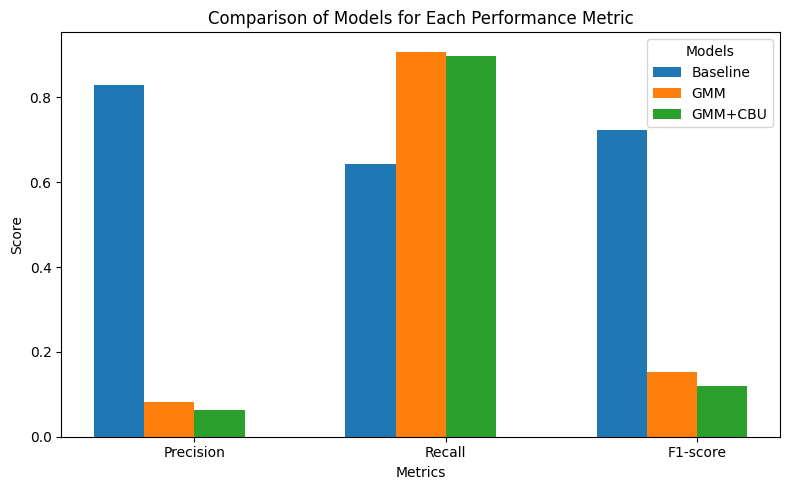

In [180]:
import numpy as np
import matplotlib.pyplot as plt

# Data
precision_scores = [precision_baseline, precision_gmm, precision_gmmcbu]
recall_scores    = [recall_baseline, recall_gmm, recall_gmmcbu]
f1_scores        = [f1_baseline, f1_gmm, f1_gmmcbu]

# Labels
models = ['Baseline', 'GMM', 'GMM+CBU']
metrics = ['Precision', 'Recall', 'F1-score']

scores = np.array([precision_scores, recall_scores, f1_scores])  

x = np.arange(len(metrics))  
width = 0.2                  

fig, ax = plt.subplots(figsize=(8, 5))

# Plot each model’s scores grouped by metric
for i, model in enumerate(models):
    ax.bar(x + i*width - (1.5*width), scores[:, i], width, label=model)

# Formatting
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Comparison of Models for Each Performance Metric')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(title="Models")

plt.tight_layout()
plt.show()

### Conclusion and Recommendations:

#### Comparison of the models

**Baseline Model**
 - The baseline model gives high precision, so whenever it detects a fraudulent transaction it is likely to be true.
 - However the recall is less compared to other models, so it is missing a lot of fradulent cases.

**GMM Model**
 - There is a significant improvement of recall when compared with the base model, that means a lot more fraudulent cases are detected.
 - However the precision reduced drastically, meaning it marks alot more non-fradulent cases as frauds.

**CBU+GMM Model**
 - Recall is around the same as that of the GMM model and better than the baseline model.
 - But the precision is sligh;lty less hwen compared to the GMM MOdel.

#### **Recommendation**

 - Recall should be the top priority as a company cannot afford to miss a fradulent cases. We can see that GMM and CBU+GMM have similar recall while baseline model has a significantly lower one.
 - We then use precision/F1 has our next prioirity. We observe that GMM does better when compared with CBU+GMM.
 - **So GMM model will be the final recommendation**. Even though its precision is less than the baseline, the recall factor gives it an edge over other models.